In [1]:
import pandas as pd
import torch
from torch import nn, optim, cuda
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader, random_split


import numpy as np
import random
from numpy.linalg import*
import matplotlib.pyplot as plt
from numpy import r_, exp, cos, sin, pi, zeros, ones, hanning, sqrt, log, floor, reshape, mean
from scipy import signal,stats 
from numpy.fft import fft
import math
import time
import scipy.optimize as opt
from sklearn.decomposition import FastICA, PCA

import scipy.io as sio
import scipy.io.wavfile
import sounddevice as sd
from IPython.display import Audio

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import copy
%matplotlib inline
import librosa
import librosa.display

import importlib
import Library_HS_210609 as lib_HS 
importlib.reload(lib_HS)

import ConvBSS_JadeICA as BSS_jica
importlib.reload(BSS_jica)

import ConvBSS_AoAPrior as BSS_prior
importlib.reload(BSS_prior)

import ConvBSS_MVDR as BSS_MVDR
importlib.reload(BSS_MVDR)

import scipy.stats as stats
import itertools 

class Lap_pdf(stats.rv_continuous):
    def _pdf(self,x,b):
        return np.exp(-abs(x)/b)/(2*b)
class Tri_pdf(stats.rv_continuous):
    def _pdf(self,x):
        return -abs(x)+1
def center(X):
    mean = np.mean(X, axis=1, keepdims=True)
    centered =  X - mean 
    return centered, mean

def covariance(X):
    mean = np.mean(X, axis=1, keepdims=True)
    n = np.shape(X)[1] - 1
    m = X - mean

    return (m.dot(m.T))/n


def whiten_strange(X):
    # Calculate the covariance matrix
    coVarM = covariance(X) 
    
    # Single value decoposition
    U, Sigma, V = np.linalg.svd(coVarM)
    print(Sigma)
    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(Sigma)) 
    
    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))
    #whiteM = np.dot(d, U.T)
    # Project onto whitening matrix
    Xw = np.dot(whiteM, X) 
    
    return Xw, whiteM

def whiten(X):
    # Calculate the covariance matrix
    Xcov = np.cov(X, rowvar=True, bias=True)
    EigVal, EigVec = np.linalg.eigh(Xcov)
    SigmaInv = np.diag(1/(EigVal+1e-9)**0.5)
    whiteM = EigVec@SigmaInv@np.transpose(EigVec)            ## ZCA implementation
    #whiteM = SigmaInv@np.transpose(EigVec)            
    Xw = whiteM@X
    return Xw, whiteM

def whiten_w_center(X):
    X,_ = center(X)
    # Calculate the covariance matrix
    Xcov = np.cov(X, rowvar=True, bias=True)
    EigVal, EigVec = np.linalg.eigh(Xcov)
    SigmaInv = np.diag(1/(EigVal+1e-9)**0.5)
    whiteM = EigVec@SigmaInv@np.transpose(EigVec)            ## ZCA implementation
    #whiteM = SigmaInv@np.transpose(EigVec)            
    Xw = whiteM@X
    return Xw, whiteM

# Define array vector
def ArrayVec_partial(M,Angle_deg, freq, vp,d):
    phi = 2*np.pi*freq*d*np.cos(Angle_deg*np.pi/180)/vp
    a = math.e**((1j*phi))
    return a

In [ ]:
#Angle = np.random.uniform(-180,180,size=(N_sample,K))     # Impinging angles of signals
print(Angle)
print(np.sort(Angle,axis=1))


In [2]:

M = 2 # Antenna array count
vp = 340    # Propagation velocity in [m/s]
d_over_lamb = 0.5   # distance between element / wavelength
fmax = 10e3
d = d_over_lamb*vp/fmax # fmax is assumed to be 10 KHz
 
N_sample = 2**16              # Generate signal samples
K =  2                           # Number of impinging singals 

f = np.random.uniform(300,3e3,size=(N_sample))
f_full = np.tile(f,(K,1)).T
#f = 1e3
#f_full = 1e3
#dtheta = np.random.uniform(-30,30,size=(N_sample))     # Rotation angle

#dtheta = np.zeros(N_sample)+90
#dtheta = np.random.normal(0,5,size=N_sample)+ 90*np.sign(np.random.normal(0,1,size=N_sample))
#dtheta = 5*np.sign(np.random.normal(0,1,size=N_sample))
#dtheta_full = np.tile(dtheta,(K,1)).T                  # Rotation angle repeated 3 times for calc.
Angle = np.sort(np.random.uniform(0,180,size=(N_sample,K)),axis=1)     # Impinging angles of signals
phi_s = np.random.uniform(0,2*np.pi,size=(N_sample,K))   # signal angle of complex S
Amp_s = np.random.uniform(0.1,10,size=(N_sample,K))        # signal amplitude of complex S
S_complex = Amp_s*math.e**(1j*phi_s)                       # Signal 
   

#before rotation
as_x = S_complex           
AS_x = np.sum(as_x,axis=1)

#after rotation
ArrayVec_y = ArrayVec_partial(M,Angle,f_full,vp,d)
as_y = ArrayVec_y*S_complex   
AS_y = np.sum(as_y,axis=1)

print(AS_x.shape)
print(AS_y.shape)

## Vectorize the data
#data_x = np.array([np.real(AS_x),np.imag(AS_x), dtheta],dtype=np.float32).T
#data_x = np.reshape(dtheta,(-1,1))
data_x = np.array([np.real(AS_x),np.imag(AS_x),f],dtype=np.float32).T
data_x = np.append(data_x,np.real(ArrayVec_y),axis=1)
data_x = np.append(data_x,np.imag(ArrayVec_y),axis=1)

#data_x = np.append(data_x,np.real(ArrayVec_x),axis=1)
#data_x = np.append(data_x,np.imag(ArrayVec_x),axis=1)
data_x = data_x.astype(np.float32)

#data_x = np.array([np.real(AS_x),np.imag(AS_x),f],dtype=np.float32).T
data_y = np.array([np.real(AS_y),np.imag(AS_y)],dtype=np.float32).T
#data_y = np.real(ArrayVec_y)
#data_y = np.append(data_y,np.real(ArrayVec_y),axis=1)
#data_y = np.append(data_y,np.imag(ArrayVec_y),axis=1)
#data_y = data_y.astype(np.float32)

print(data_x.shape)
print(data_y.shape)





(65536,)
(65536,)
(65536, 7)
(65536, 2)


In [ ]:
type(data_x)
print(dtheta)

In [ ]:
print(data_x)
print(data_y)

In [3]:
## Using Dataloader
Nbits_train = 2**14
x_train = torch.from_numpy(data_x[:Nbits_train])
y_train = torch.from_numpy(data_y[:Nbits_train])
x_valid = torch.from_numpy(data_x[Nbits_train:2*Nbits_train])
y_valid = torch.from_numpy(data_y[Nbits_train:2*Nbits_train])

dataset = TensorDataset(x_train, y_train)
validset = TensorDataset(x_valid, y_valid)

batch_N= 1024
dataloader = DataLoader(dataset, batch_size=batch_N, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_N, shuffle=True)



model = torch.nn.Sequential(
   
    
    torch.nn.Linear(len(data_x[0,:]),256, bias=True),
    torch.nn.Dropout(p=0.2),
    #torch.nn.BatchNorm1d(100), #applying batch norm
    torch.nn.LeakyReLU(0.01),
    torch.nn.Linear(256,128, bias=True),
    torch.nn.Dropout(p=0.2),
    #torch.nn.BatchNorm1d(500), #applying batch norm
    torch.nn.LeakyReLU(0.01),
    torch.nn.Linear(128,64, bias=True),
    torch.nn.Dropout(p=0.2),
    torch.nn.LeakyReLU(0.01),  
    #torch.nn.ReLU(),
    torch.nn.Linear(64,2, bias=True),
 
)

num_epoch = 30000

loss_function = torch.nn.MSELoss()

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_history = []
valid_loss_history = []
for epoch in range(num_epoch+1):

    model.train()
    for batch_idx, samples in enumerate(dataloader):
        input, target = samples

        # forward
        out = model(input)      
        loss = loss_function(out, target)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # show
        if epoch % 100 == 0:

            print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
                epoch, num_epoch, batch_idx+1, len(dataloader),
                loss.item()
                ))
        loss_history.append(loss.item())

    model.eval()
    for data, labels in validloader:
        out_valid = model(data)
        valid_loss = loss_function(out_valid,labels)
        if epoch % 100 == 0:

            print('valid_Cost: {:.6f}'.format(
                valid_loss.item()
                ))    
        valid_loss_history.append(valid_loss.item())
plt.plot(loss_history)
plt.ylabel("Total loss")
plt.xlabel("Epochs")



Epoch    0/30000 Batch 1/16 Cost: 984.802429
Epoch    0/30000 Batch 2/16 Cost: 437.887817
Epoch    0/30000 Batch 3/16 Cost: 459.591370
Epoch    0/30000 Batch 4/16 Cost: 302.440552
Epoch    0/30000 Batch 5/16 Cost: 186.818497
Epoch    0/30000 Batch 6/16 Cost: 134.485931
Epoch    0/30000 Batch 7/16 Cost: 131.701447
Epoch    0/30000 Batch 8/16 Cost: 112.687408
Epoch    0/30000 Batch 9/16 Cost: 98.222176
Epoch    0/30000 Batch 10/16 Cost: 86.288177
Epoch    0/30000 Batch 11/16 Cost: 78.941231
Epoch    0/30000 Batch 12/16 Cost: 70.517296
Epoch    0/30000 Batch 13/16 Cost: 71.502762
Epoch    0/30000 Batch 14/16 Cost: 66.131714
Epoch    0/30000 Batch 15/16 Cost: 64.019798
Epoch    0/30000 Batch 16/16 Cost: 66.205009
valid_Cost: 41.715023
valid_Cost: 39.261837
valid_Cost: 38.022400
valid_Cost: 40.538055
valid_Cost: 40.578697
valid_Cost: 38.196453
valid_Cost: 39.729214
valid_Cost: 39.554523
valid_Cost: 38.709450
valid_Cost: 40.485519
valid_Cost: 40.224674
valid_Cost: 38.226776
valid_Cost: 41.10

Epoch  800/30000 Batch 1/16 Cost: 3.182485
Epoch  800/30000 Batch 2/16 Cost: 3.462542
Epoch  800/30000 Batch 3/16 Cost: 3.425165
Epoch  800/30000 Batch 4/16 Cost: 3.884988
Epoch  800/30000 Batch 5/16 Cost: 3.574286
Epoch  800/30000 Batch 6/16 Cost: 3.330351
Epoch  800/30000 Batch 7/16 Cost: 3.390081
Epoch  800/30000 Batch 8/16 Cost: 3.440006
Epoch  800/30000 Batch 9/16 Cost: 3.348688
Epoch  800/30000 Batch 10/16 Cost: 3.684015
Epoch  800/30000 Batch 11/16 Cost: 3.227752
Epoch  800/30000 Batch 12/16 Cost: 3.390730
Epoch  800/30000 Batch 13/16 Cost: 3.679031
Epoch  800/30000 Batch 14/16 Cost: 3.110608
Epoch  800/30000 Batch 15/16 Cost: 3.219665
Epoch  800/30000 Batch 16/16 Cost: 3.192673
valid_Cost: 3.220883
valid_Cost: 3.170044
valid_Cost: 3.211157
valid_Cost: 2.925417
valid_Cost: 3.301435
valid_Cost: 3.283173
valid_Cost: 3.167140
valid_Cost: 3.491000
valid_Cost: 3.220291
valid_Cost: 3.139258
valid_Cost: 3.284342
valid_Cost: 3.142698
valid_Cost: 3.350419
valid_Cost: 3.567719
valid_Cost:

Epoch 1600/30000 Batch 1/16 Cost: 3.082740
Epoch 1600/30000 Batch 2/16 Cost: 2.975209
Epoch 1600/30000 Batch 3/16 Cost: 2.903785
Epoch 1600/30000 Batch 4/16 Cost: 3.194106
Epoch 1600/30000 Batch 5/16 Cost: 3.162761
Epoch 1600/30000 Batch 6/16 Cost: 3.152279
Epoch 1600/30000 Batch 7/16 Cost: 3.200480
Epoch 1600/30000 Batch 8/16 Cost: 3.144176
Epoch 1600/30000 Batch 9/16 Cost: 3.130696
Epoch 1600/30000 Batch 10/16 Cost: 3.492672
Epoch 1600/30000 Batch 11/16 Cost: 3.046644
Epoch 1600/30000 Batch 12/16 Cost: 2.883694
Epoch 1600/30000 Batch 13/16 Cost: 3.056710
Epoch 1600/30000 Batch 14/16 Cost: 2.841858
Epoch 1600/30000 Batch 15/16 Cost: 2.959313
Epoch 1600/30000 Batch 16/16 Cost: 3.108366
valid_Cost: 3.405267
valid_Cost: 3.407485
valid_Cost: 3.315071
valid_Cost: 3.452772
valid_Cost: 3.654792
valid_Cost: 3.652386
valid_Cost: 3.871186
valid_Cost: 3.784966
valid_Cost: 3.550129
valid_Cost: 3.479284
valid_Cost: 3.245462
valid_Cost: 3.207110
valid_Cost: 3.321270
valid_Cost: 3.462891
valid_Cost:

valid_Cost: 3.772636
Epoch 2400/30000 Batch 1/16 Cost: 3.067864
Epoch 2400/30000 Batch 2/16 Cost: 2.889459
Epoch 2400/30000 Batch 3/16 Cost: 3.204137
Epoch 2400/30000 Batch 4/16 Cost: 3.290323
Epoch 2400/30000 Batch 5/16 Cost: 2.969993
Epoch 2400/30000 Batch 6/16 Cost: 2.987453
Epoch 2400/30000 Batch 7/16 Cost: 2.906760
Epoch 2400/30000 Batch 8/16 Cost: 3.142873
Epoch 2400/30000 Batch 9/16 Cost: 3.074472
Epoch 2400/30000 Batch 10/16 Cost: 3.198588
Epoch 2400/30000 Batch 11/16 Cost: 2.948305
Epoch 2400/30000 Batch 12/16 Cost: 2.967263
Epoch 2400/30000 Batch 13/16 Cost: 3.213248
Epoch 2400/30000 Batch 14/16 Cost: 2.873245
Epoch 2400/30000 Batch 15/16 Cost: 3.178541
Epoch 2400/30000 Batch 16/16 Cost: 2.974246
valid_Cost: 3.450070
valid_Cost: 3.601318
valid_Cost: 3.787509
valid_Cost: 3.292980
valid_Cost: 3.607931
valid_Cost: 3.685019
valid_Cost: 3.448245
valid_Cost: 3.490548
valid_Cost: 3.206502
valid_Cost: 3.565414
valid_Cost: 3.753925
valid_Cost: 3.552776
valid_Cost: 3.659528
valid_Cost:

Epoch 3200/30000 Batch 1/16 Cost: 2.880797
Epoch 3200/30000 Batch 2/16 Cost: 3.119463
Epoch 3200/30000 Batch 3/16 Cost: 2.936545
Epoch 3200/30000 Batch 4/16 Cost: 3.178207
Epoch 3200/30000 Batch 5/16 Cost: 2.981429
Epoch 3200/30000 Batch 6/16 Cost: 3.310899
Epoch 3200/30000 Batch 7/16 Cost: 3.378483
Epoch 3200/30000 Batch 8/16 Cost: 2.838550
Epoch 3200/30000 Batch 9/16 Cost: 3.213667
Epoch 3200/30000 Batch 10/16 Cost: 2.731977
Epoch 3200/30000 Batch 11/16 Cost: 3.199721
Epoch 3200/30000 Batch 12/16 Cost: 2.949263
Epoch 3200/30000 Batch 13/16 Cost: 2.953844
Epoch 3200/30000 Batch 14/16 Cost: 3.250821
Epoch 3200/30000 Batch 15/16 Cost: 2.801616
Epoch 3200/30000 Batch 16/16 Cost: 3.024742
valid_Cost: 3.491339
valid_Cost: 3.732893
valid_Cost: 3.748573
valid_Cost: 3.233027
valid_Cost: 3.763180
valid_Cost: 3.399393
valid_Cost: 3.795900
valid_Cost: 3.224271
valid_Cost: 3.670741
valid_Cost: 3.711171
valid_Cost: 3.377856
valid_Cost: 3.580001
valid_Cost: 3.351616
valid_Cost: 3.519195
valid_Cost:

Epoch 4000/30000 Batch 1/16 Cost: 3.227302
Epoch 4000/30000 Batch 2/16 Cost: 2.741155
Epoch 4000/30000 Batch 3/16 Cost: 3.003287
Epoch 4000/30000 Batch 4/16 Cost: 2.880711
Epoch 4000/30000 Batch 5/16 Cost: 2.842714
Epoch 4000/30000 Batch 6/16 Cost: 2.963699
Epoch 4000/30000 Batch 7/16 Cost: 2.908215
Epoch 4000/30000 Batch 8/16 Cost: 3.252118
Epoch 4000/30000 Batch 9/16 Cost: 3.272737
Epoch 4000/30000 Batch 10/16 Cost: 3.157286
Epoch 4000/30000 Batch 11/16 Cost: 2.907682
Epoch 4000/30000 Batch 12/16 Cost: 3.117317
Epoch 4000/30000 Batch 13/16 Cost: 2.857874
Epoch 4000/30000 Batch 14/16 Cost: 2.686977
Epoch 4000/30000 Batch 15/16 Cost: 2.943050
Epoch 4000/30000 Batch 16/16 Cost: 3.031033
valid_Cost: 3.425387
valid_Cost: 3.588635
valid_Cost: 3.800054
valid_Cost: 3.665132
valid_Cost: 3.965544
valid_Cost: 3.871954
valid_Cost: 3.635444
valid_Cost: 4.271358
valid_Cost: 3.563406
valid_Cost: 3.938633
valid_Cost: 3.816912
valid_Cost: 3.691202
valid_Cost: 3.537746
valid_Cost: 3.495069
valid_Cost:

Epoch 4800/30000 Batch 1/16 Cost: 3.362682
Epoch 4800/30000 Batch 2/16 Cost: 2.968641
Epoch 4800/30000 Batch 3/16 Cost: 2.931698
Epoch 4800/30000 Batch 4/16 Cost: 2.695395
Epoch 4800/30000 Batch 5/16 Cost: 2.755418
Epoch 4800/30000 Batch 6/16 Cost: 2.708104
Epoch 4800/30000 Batch 7/16 Cost: 3.052152
Epoch 4800/30000 Batch 8/16 Cost: 2.896717
Epoch 4800/30000 Batch 9/16 Cost: 2.878674
Epoch 4800/30000 Batch 10/16 Cost: 2.825862
Epoch 4800/30000 Batch 11/16 Cost: 3.516346
Epoch 4800/30000 Batch 12/16 Cost: 2.912483
Epoch 4800/30000 Batch 13/16 Cost: 3.029606
Epoch 4800/30000 Batch 14/16 Cost: 2.889833
Epoch 4800/30000 Batch 15/16 Cost: 3.009050
Epoch 4800/30000 Batch 16/16 Cost: 2.838497
valid_Cost: 3.908521
valid_Cost: 3.576246
valid_Cost: 3.866169
valid_Cost: 3.715970
valid_Cost: 3.847968
valid_Cost: 3.628607
valid_Cost: 3.437158
valid_Cost: 3.591558
valid_Cost: 3.474526
valid_Cost: 3.549039
valid_Cost: 3.219829
valid_Cost: 3.863670
valid_Cost: 3.921564
valid_Cost: 3.579271
valid_Cost:

Epoch 5600/30000 Batch 1/16 Cost: 3.029047
Epoch 5600/30000 Batch 2/16 Cost: 3.177009
Epoch 5600/30000 Batch 3/16 Cost: 2.990825
Epoch 5600/30000 Batch 4/16 Cost: 2.639337
Epoch 5600/30000 Batch 5/16 Cost: 2.802184
Epoch 5600/30000 Batch 6/16 Cost: 2.707674
Epoch 5600/30000 Batch 7/16 Cost: 2.916435
Epoch 5600/30000 Batch 8/16 Cost: 3.034669
Epoch 5600/30000 Batch 9/16 Cost: 3.029199
Epoch 5600/30000 Batch 10/16 Cost: 2.932219
Epoch 5600/30000 Batch 11/16 Cost: 2.914984
Epoch 5600/30000 Batch 12/16 Cost: 3.073339
Epoch 5600/30000 Batch 13/16 Cost: 3.437826
Epoch 5600/30000 Batch 14/16 Cost: 2.740000
Epoch 5600/30000 Batch 15/16 Cost: 3.125066
Epoch 5600/30000 Batch 16/16 Cost: 2.883663
valid_Cost: 3.737684
valid_Cost: 4.150659
valid_Cost: 3.885126
valid_Cost: 3.903575
valid_Cost: 4.151122
valid_Cost: 3.733378
valid_Cost: 3.945932
valid_Cost: 3.778135
valid_Cost: 4.068901
valid_Cost: 3.939244
valid_Cost: 3.756919
valid_Cost: 3.832693
valid_Cost: 4.119101
valid_Cost: 3.788608
valid_Cost:

Epoch 6400/30000 Batch 1/16 Cost: 2.801460
Epoch 6400/30000 Batch 2/16 Cost: 2.819641
Epoch 6400/30000 Batch 3/16 Cost: 2.862958
Epoch 6400/30000 Batch 4/16 Cost: 2.998719
Epoch 6400/30000 Batch 5/16 Cost: 3.048685
Epoch 6400/30000 Batch 6/16 Cost: 3.002293
Epoch 6400/30000 Batch 7/16 Cost: 3.301667
Epoch 6400/30000 Batch 8/16 Cost: 3.183689
Epoch 6400/30000 Batch 9/16 Cost: 3.126093
Epoch 6400/30000 Batch 10/16 Cost: 2.808870
Epoch 6400/30000 Batch 11/16 Cost: 2.744333
Epoch 6400/30000 Batch 12/16 Cost: 2.815792
Epoch 6400/30000 Batch 13/16 Cost: 2.957811
Epoch 6400/30000 Batch 14/16 Cost: 3.094450
Epoch 6400/30000 Batch 15/16 Cost: 2.789108
Epoch 6400/30000 Batch 16/16 Cost: 2.941223
valid_Cost: 3.748558
valid_Cost: 3.424319
valid_Cost: 3.735798
valid_Cost: 3.791187
valid_Cost: 3.625514
valid_Cost: 3.555581
valid_Cost: 3.493778
valid_Cost: 3.574584
valid_Cost: 3.635410
valid_Cost: 3.886084
valid_Cost: 3.466764
valid_Cost: 3.591383
valid_Cost: 3.849676
valid_Cost: 3.719246
valid_Cost:

Epoch 7200/30000 Batch 1/16 Cost: 2.924899
Epoch 7200/30000 Batch 2/16 Cost: 3.208529
Epoch 7200/30000 Batch 3/16 Cost: 2.793912
Epoch 7200/30000 Batch 4/16 Cost: 2.904036
Epoch 7200/30000 Batch 5/16 Cost: 2.787564
Epoch 7200/30000 Batch 6/16 Cost: 3.179809
Epoch 7200/30000 Batch 7/16 Cost: 3.057488
Epoch 7200/30000 Batch 8/16 Cost: 2.638438
Epoch 7200/30000 Batch 9/16 Cost: 2.914365
Epoch 7200/30000 Batch 10/16 Cost: 2.826173
Epoch 7200/30000 Batch 11/16 Cost: 3.147777
Epoch 7200/30000 Batch 12/16 Cost: 3.253484
Epoch 7200/30000 Batch 13/16 Cost: 2.949903
Epoch 7200/30000 Batch 14/16 Cost: 2.700365
Epoch 7200/30000 Batch 15/16 Cost: 3.064739
Epoch 7200/30000 Batch 16/16 Cost: 2.991976
valid_Cost: 3.934890
valid_Cost: 4.011110
valid_Cost: 3.849918
valid_Cost: 4.036078
valid_Cost: 3.979823
valid_Cost: 3.565717
valid_Cost: 4.271893
valid_Cost: 3.786047
valid_Cost: 3.977835
valid_Cost: 3.585567
valid_Cost: 3.930498
valid_Cost: 3.703780
valid_Cost: 3.647980
valid_Cost: 3.499959
valid_Cost:

Epoch 8000/30000 Batch 1/16 Cost: 2.656338
Epoch 8000/30000 Batch 2/16 Cost: 2.643403
Epoch 8000/30000 Batch 3/16 Cost: 2.901275
Epoch 8000/30000 Batch 4/16 Cost: 3.058053
Epoch 8000/30000 Batch 5/16 Cost: 2.847060
Epoch 8000/30000 Batch 6/16 Cost: 3.057287
Epoch 8000/30000 Batch 7/16 Cost: 2.840441
Epoch 8000/30000 Batch 8/16 Cost: 2.916693
Epoch 8000/30000 Batch 9/16 Cost: 2.666279
Epoch 8000/30000 Batch 10/16 Cost: 3.268751
Epoch 8000/30000 Batch 11/16 Cost: 3.137276
Epoch 8000/30000 Batch 12/16 Cost: 3.004782
Epoch 8000/30000 Batch 13/16 Cost: 3.035767
Epoch 8000/30000 Batch 14/16 Cost: 2.927079
Epoch 8000/30000 Batch 15/16 Cost: 2.721460
Epoch 8000/30000 Batch 16/16 Cost: 2.850707
valid_Cost: 3.555865
valid_Cost: 3.739539
valid_Cost: 3.591513
valid_Cost: 3.416082
valid_Cost: 3.919962
valid_Cost: 3.474311
valid_Cost: 3.451066
valid_Cost: 3.787161
valid_Cost: 3.794384
valid_Cost: 3.847770
valid_Cost: 3.876391
valid_Cost: 3.489151
valid_Cost: 3.250230
valid_Cost: 3.550755
valid_Cost:

Epoch 8800/30000 Batch 1/16 Cost: 2.821316
Epoch 8800/30000 Batch 2/16 Cost: 3.021992
Epoch 8800/30000 Batch 3/16 Cost: 2.805292
Epoch 8800/30000 Batch 4/16 Cost: 3.106874
Epoch 8800/30000 Batch 5/16 Cost: 2.866650
Epoch 8800/30000 Batch 6/16 Cost: 2.884323
Epoch 8800/30000 Batch 7/16 Cost: 2.833594
Epoch 8800/30000 Batch 8/16 Cost: 3.039541
Epoch 8800/30000 Batch 9/16 Cost: 2.601749
Epoch 8800/30000 Batch 10/16 Cost: 2.901963
Epoch 8800/30000 Batch 11/16 Cost: 2.796184
Epoch 8800/30000 Batch 12/16 Cost: 2.906114
Epoch 8800/30000 Batch 13/16 Cost: 3.068287
Epoch 8800/30000 Batch 14/16 Cost: 3.176540
Epoch 8800/30000 Batch 15/16 Cost: 2.930461
Epoch 8800/30000 Batch 16/16 Cost: 2.875927
valid_Cost: 3.534642
valid_Cost: 3.716352
valid_Cost: 3.924953
valid_Cost: 4.050754
valid_Cost: 3.618327
valid_Cost: 3.603272
valid_Cost: 3.690432
valid_Cost: 3.724444
valid_Cost: 3.880084
valid_Cost: 3.687969
valid_Cost: 3.922664
valid_Cost: 3.817595
valid_Cost: 3.705531
valid_Cost: 3.968217
valid_Cost:

Epoch 9600/30000 Batch 1/16 Cost: 2.674222
Epoch 9600/30000 Batch 2/16 Cost: 2.855721
Epoch 9600/30000 Batch 3/16 Cost: 3.245631
Epoch 9600/30000 Batch 4/16 Cost: 3.191398
Epoch 9600/30000 Batch 5/16 Cost: 3.030718
Epoch 9600/30000 Batch 6/16 Cost: 3.088749
Epoch 9600/30000 Batch 7/16 Cost: 2.786983
Epoch 9600/30000 Batch 8/16 Cost: 2.713484
Epoch 9600/30000 Batch 9/16 Cost: 3.053795
Epoch 9600/30000 Batch 10/16 Cost: 2.772649
Epoch 9600/30000 Batch 11/16 Cost: 2.656086
Epoch 9600/30000 Batch 12/16 Cost: 3.096728
Epoch 9600/30000 Batch 13/16 Cost: 2.566000
Epoch 9600/30000 Batch 14/16 Cost: 3.054304
Epoch 9600/30000 Batch 15/16 Cost: 2.807138
Epoch 9600/30000 Batch 16/16 Cost: 2.932052
valid_Cost: 3.671565
valid_Cost: 3.624747
valid_Cost: 3.784305
valid_Cost: 3.929954
valid_Cost: 3.732625
valid_Cost: 3.942344
valid_Cost: 3.912962
valid_Cost: 3.426295
valid_Cost: 3.252996
valid_Cost: 3.622488
valid_Cost: 3.794898
valid_Cost: 3.388486
valid_Cost: 3.639323
valid_Cost: 3.970831
valid_Cost:

Epoch 10400/30000 Batch 1/16 Cost: 2.869323
Epoch 10400/30000 Batch 2/16 Cost: 2.881320
Epoch 10400/30000 Batch 3/16 Cost: 2.793631
Epoch 10400/30000 Batch 4/16 Cost: 2.925768
Epoch 10400/30000 Batch 5/16 Cost: 2.849881
Epoch 10400/30000 Batch 6/16 Cost: 2.904317
Epoch 10400/30000 Batch 7/16 Cost: 2.998509
Epoch 10400/30000 Batch 8/16 Cost: 2.864308
Epoch 10400/30000 Batch 9/16 Cost: 3.078640
Epoch 10400/30000 Batch 10/16 Cost: 2.734060
Epoch 10400/30000 Batch 11/16 Cost: 3.177348
Epoch 10400/30000 Batch 12/16 Cost: 2.849322
Epoch 10400/30000 Batch 13/16 Cost: 2.966116
Epoch 10400/30000 Batch 14/16 Cost: 3.213897
Epoch 10400/30000 Batch 15/16 Cost: 3.052226
Epoch 10400/30000 Batch 16/16 Cost: 2.864583
valid_Cost: 3.616607
valid_Cost: 3.938292
valid_Cost: 3.569128
valid_Cost: 3.494805
valid_Cost: 3.802699
valid_Cost: 3.528143
valid_Cost: 3.727739
valid_Cost: 3.586569
valid_Cost: 3.600212
valid_Cost: 3.710458
valid_Cost: 3.644833
valid_Cost: 3.667900
valid_Cost: 3.739249
valid_Cost: 3.53

KeyboardInterrupt: 

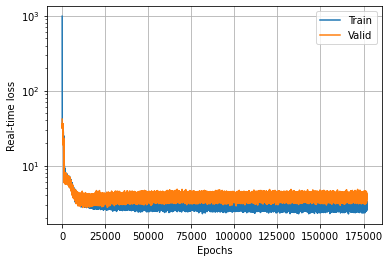

In [4]:
plt.plot(loss_history,'-' ,label = 'Train')
plt.plot(valid_loss_history,'-' ,label = 'Valid')
plt.yscale("log")
plt.ylabel("Real-time loss")
plt.xlabel("Epochs")
plt.legend()
plt.grid()

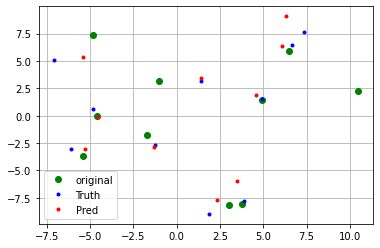

In [5]:
## Trained data

Disp = 10
TrainOut= model(x_train).detach().numpy()
plt.plot(x_train[:Disp,0],x_train[:Disp,1], 'o',label='original',color='g')
plt.plot(y_train[:Disp,0],y_train[:Disp,1],'.',label='Truth',color='b')
plt.plot(TrainOut[:Disp,0], TrainOut[:Disp,1], '.',label='Pred',color='r')
plt.legend()
plt.grid()
plt.show()

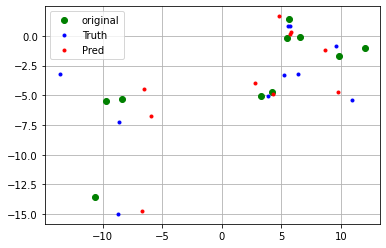

In [7]:
## Testing 

Disp = 10
TestOut= model(torch.tensor(data_x, dtype=torch.float32)).detach().numpy()

plt.plot(data_x[Nbits_train:Nbits_train+Disp,0],data_x[Nbits_train:Nbits_train+Disp,1], 'o',label='original',color='g')
plt.plot(data_y[Nbits_train:Nbits_train+Disp,0],data_y[Nbits_train:Nbits_train+Disp,1], '.',label='Truth',color='b')
plt.plot(TestOut[Nbits_train:Nbits_train+Disp,0],TestOut[Nbits_train:Nbits_train+Disp,1],  '.',label='Pred',color='r')

#plt.plot(data_x[Nbits_train:Nbits_train+Disp,0], 'o',label='original',color='g')
#plt.plot(data_y[Nbits_train:Nbits_train+Disp,5], '*',label='Truth',color='b')
#plt.plot(TestOut[Nbits_train:Nbits_train+Disp,5], 'x',label='Pred',color='r')
plt.legend()
plt.grid()
plt.show()

In [ ]:
### Model 저장할때 파라미터 보기

print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

In [8]:
## Save entire model
torch.save(model, './DNNsave/210920/model_name.pt')
torch.save(model.state_dict(), './DNNsave/210920/model_state_dict.pt')
torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict()}, './DNNsave/210920/all.tar')


torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, './DNNsave/210920/paused.tar')

In [ ]:
## Test 1

'''
#data_x = np.reshape(dtheta,(-1,1))
data_x = np.array([np.real(AS_x),np.imag(AS_x),f],dtype=np.float32).T
data_x = np.append(data_x,Angle,axis=1)
data_x = np.append(data_x,np.real(ArrayVec_y),axis=1)
data_x = np.append(data_x,np.imag(ArrayVec_y),axis=1)

#data_x = np.append(data_x,np.real(ArrayVec_x),axis=1)
#data_x = np.append(data_x,np.imag(ArrayVec_x),axis=1)
data_x = data_x.astype(np.float32)

#data_x = np.array([np.real(AS_x),np.imag(AS_x),f],dtype=np.float32).T
data_y = np.array([np.real(AS_y),np.imag(AS_y)],dtype=np.float32).T
'''


Angle_test = np.array([-10,50,150])
#Angle_test = np.array([51.6,97.2,108])
#Angle_test = np.array([5,10,-2])
S_test = np.array([5+3j, 2+3j, -4+1j])
#S_test = np.array([-0.39+2.05j, 4.48-0.77j, 3.59-6.82j])
#S_test = np.array([-5, 0.2+3j, -4+1j])
X = 0
Y = 0
rot = -10
f_test = 1000
for i in range(K):
    X = X + ArrayVec_partial(M,Angle_test[i],f_test,vp,d)*S_test[i]
    Y = Y + ArrayVec_partial(M,Angle_test[i]+rot,f_test,vp,d)*S_test[i]
print(X,Y)
Input_test = np.array([np.real(X),np.imag(X),f_test])
Input_test = np.append(Input_test,Angle_test)
Input_test = np.append(Input_test,np.real(ArrayVec_partial(M,Angle_test+rot,f_test,vp,d)))
Input_test = np.append(Input_test,np.imag(ArrayVec_partial(M,Angle_test+rot,f_test,vp,d)))
Input_test = Input_test.astype(np.float32)
#Input_test = np.tile([np.real(X),np.imag(X),rot],(2,1))

print(Input_test)
print(model(torch.tensor(Input_test,dtype=torch.float32)).detach().numpy())

In [ ]:
print(S_complex[0,:])
print(Angle[0,:])
print(f[0])
print(dtheta[0])

print(x_train[0,:])
print(y_train[0,:])

print(model(x_train[0,:]).detach().numpy())
#TrainOut= model(x_train).detach().numpy()

#plt.plot(y_train[:Disp,0],y_train[:Disp,1], '.',label='Truth')
#plt.plot(TrainOut[:Disp,0], TrainOut[:Disp,1], '.',label='Pred')

In [ ]:
### Original approach of mine


Nbits=len(data_x[:,0])
#Nbits = len(data_x)
Nbits_train=5000

x_train = torch.from_numpy(data_x[:Nbits_train])
#x_train = torch.FloatTensor(x_train).unsqueeze(1)
y_train = torch.from_numpy(data_y[:Nbits_train])
#y_train = torch.FloatTensor(y_train).unsqueeze(1)

#print(x_train)
#print(y_train)

model = torch.nn.Sequential(
#    nn.Linear(1, 2048),  
#    nn.Tanh(),
#    nn.Linear(2048, 1)     
    

    torch.nn.Linear(len(data_x[0,:]),300, bias=True),
    #torch.nn.BatchNorm1d(100), #applying batch norm
    torch.nn.LeakyReLU(0.1),
    #torch.nn.ReLU(),
    torch.nn.Linear(300,500, bias=True),
    #torch.nn.BatchNorm1d(100), #applying batch norm
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(500,300, bias=True),
    #torch.nn.BatchNorm1d(100), #applying batch norm
    torch.nn.LeakyReLU(0.1),

    
    
    #torch.nn.ReLU(),
    torch.nn.Linear(300,2, bias=True),

    
    
)

print(model)

num_epoch = 10000

loss_function = torch.nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_history = []
for epoch in range(num_epoch):
    input = Variable(x_train)
    target = Variable(y_train)

    # forward
    out = model(input)
    loss = loss_function(out, target)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # show
    if epoch % 100 == 0:
        
        print(loss.data.item())
        #print('Epoch[{}/{}], loss: {:.6f}'
        #  .format(epoch + 1, num_epoch, loss.data.item()))
    
    loss_history.append(loss.data.item())
             

plt.plot(loss_history)
plt.ylabel("Total loss")
plt.xlabel("Epochs")

In [ ]:
plt.plot(loss_history)
plt.yscale("log")
plt.ylabel("Real-time loss")
plt.xlabel("Epochs")
#plt.ylim([0,10])

In [ ]:
print(np.argmax(loss_history))
#print(loss_history[20772])


In [ ]:
print(x_train[:10])
print(model(x_train[:10]))
print(y_train[:10])

In [ ]:
## Trained data

Disp = 100
TrainOut= model(x_train).detach().numpy()
plt.plot(x_train[:Disp,0],x_train[:Disp,1], '.',label='original')
plt.plot(y_train[:Disp,0],y_train[:Disp,1], '.',label='Truth')
plt.plot(TrainOut[:Disp,0], TrainOut[:Disp,1], '.',label='Pred')
plt.legend()
plt.show()

In [ ]:
## Testing 

Disp = 3
TestOut= model(torch.tensor(data_x, dtype=torch.float32)).detach().numpy()
plt.plot(data_x[Nbits_train:Nbits_train+Disp,0],data_x[Nbits_train:Nbits_train+Disp,1], 'o',color = 'g', label='original')
plt.plot(data_y[Nbits_train:Nbits_train+Disp,0],data_y[Nbits_train:Nbits_train+Disp,1], '*',color = 'b', label='Truth')
plt.plot(TestOut[Nbits_train:Nbits_train+Disp,0], TestOut[Nbits_train:Nbits_train+Disp,1], 'x',color='r',label='Pred')



plt.legend()
plt.show()


In [ ]:
(torch.tensor([np.real(X),np.imag(X),-10,1e3],dtype=torch.float32)).detach().numpy()

In [ ]:
print(x_train[:5])
print(y_train[:5])

In [ ]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data

# save to csv file
savetxt('data_y_HS.csv', data_y, delimiter=',')
savetxt('data_x_HS.csv', data_x, delimiter=',')


In [ ]:
# Error (distance between symbol and symbol_RX)
#Err_dist=0
#for i in range(256,Nbits):
#    Err_dist+=np.sqrt(np.real(symbol[i]-symbol_RX[i])**2+np.imag(symbol[i]-symbol_RX[i])**2)
#    
#print(Err_dist/(Nbits-256-1))

# Accuracy of bits
Count=0
icount=0
Accuracy=0
bits_DNN=np.zeros(Nbits-Nbits_train)
for i in range(Nbits_train,Nbits):
    icount+=1
    bits_DNN[i-Nbits_train]=np.argmax(model(torch.tensor([data_x[i]], dtype=torch.float32)).detach().numpy()) 
    if np.argmax(data_y[i])==np.argmax(model(torch.tensor([data_x[i]], dtype=torch.float32)).detach().numpy()):    
        Count+=1
Accuracy = Count/(Nbits-Nbits_train) 
print(icount)
print(bits_DNN.size)
print("Total symbol bits:", Nbits-Nbits_train)
print("Correct bits", Count)
print("Accuracy(%):",100*Accuracy, "%")

In [ ]:
T1= model(torch.tensor(data_x, dtype=torch.float32)).detach().numpy()

In [ ]:
print(T1)
print(data_y)

In [ ]:
print(data_x.shape)

In [ ]:
### data_read

fs_true, HSdata = sio.wavfile.read('./VoiceRecords/AugRecord.wav')
_, JPdata = sio.wavfile.read('./VoiceRecords/JuneRecord.wav')
HSdata = HSdata[:,0]
JPdata = JPdata[:,0]

# Signal Generation

# Linear Arrays referenced at the edge of element (index = 0).
i_pair = np.array([0,2])
Angle = np.array([120,80,-20]) #, 70])#, -45, -5])#, 30, 45, 65])     # Impinging Angles from the right
#Angle = np.array([-30,120,30])
#Angle = np.array([30,-30,120])

#dtheta = -80
#Angle = Angle - dtheta
#Angle = Angle+ -np.average(Angle[i_pair])
print(Angle)


M = 2 # Antenna array count
vp = 340    # Propagation velocity in [m/s]
d_over_lamb = 0.5   # distance between element / wavelength
fmax = 10e3
d = d_over_lamb*vp/fmax # fmax is assumed to be 10 KHz


K = len(Angle)      #  Number of impinging signals

data_i = np.zeros((K,50000))
data_i[0,:] = JPdata[160000:210000]   # 0.25 second signal
#data_i[1,:] = JPdata[210000:260000]
data_i[1,:] = HSdata[50000:100000]
#data_i[2,:] = HSdata[50000:150000]
#data_i[2,:] = JPdata[60000:160000]
#data_i[3,:] = HSdata[125000:175000]
data_i[2,:] = HSdata[170000:220000] 


# Add zero pad if sample length is odd
if len(data_i[0,:])%2!=0:
    data_i = np.pad(data_i,pad_width = ((0, 0), (0, 1)), constant_values=0)

Ns_true = len(data_i[0,:])    # Sample number 
t_true = np.arange(Ns_true)/fs_true
SigVec = np.zeros((K,Ns_true))

for i in range(K):
    SigVec[i,:] = (data_i[i,:])# - np.average(data_i[i,:]))


############## Lowpass filtered signals will be recovered.
#SigVec[0,:] = lib_HS.butter_lowpass_filter(SigVec[0,:], fmax, fs_true, order=5)  # square signal
#SigVec[1,:] = lib_HS.butter_lowpass_filter(SigVec[1,:], fmax, fs_true, order=5)  # saw tooth signal    
    
factor_ups = 10
SNR = 100
X = lib_HS.MixGen(SigVec, Angle, M, fs_true, SNR, factor_ups, vp, d)    

Disp = 100
plt.plot(t_true[:Disp],X[0,:Disp],label='Ref')
plt.plot(t_true[:Disp],X[1,:Disp],label = 'MIC Last')
plt.legend()

fig, ax = plt.subplots(1, 2, figsize=[8, 4])
ax[0].scatter(SigVec[0], SigVec[1])
ax[0].tick_params(labelsize=12)
ax[0].set_xlabel('signal 1', fontsize=15)
ax[0].set_title('Originals signals', fontsize=20)

Audio(X[1,:], rate=fs_true)

In [ ]:
L_frame = 512              ## freq bin number = L_frame
S_frame = 0.25*L_frame
f, t, _ = signal.stft(X[0,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
X_ft = np.zeros((M,len(f),len(t)), dtype='complex')
S_ft = np.zeros((K,len(f),len(t)), dtype='complex')
for i in range(M):
    _, _, X_ft[i,:,:] = signal.stft(X[i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)  
    
for i in range(K):
    _, _, S_ft[i,:,:] = signal.stft(SigVec[i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)  
# hopsize H = nperseg - noverlap


magnitudeZxx = np.abs(X_ft[0,:,:])
log_spectrogramZxx = librosa.amplitude_to_db(magnitudeZxx)#-60

plt.figure(figsize=(10,4))
librosa.display.specshow(log_spectrogramZxx, sr=fs_true, x_axis='time', y_axis='linear', hop_length=S_frame) #,cmap=plt.cm.gist_heat)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

print('X_tf shape:', X_ft.shape)
print('freq sample:', f.shape)
print('time sample:', t.shape)

## istft code
#   _, xrec = signal.istft(Zxx, fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)

In [ ]:
## Apply ICA after rotation   --Tentative 
N_fft = 512
N_hop = N_fft*0.25

#f_LPF = 0.1*fs_true
f_LPF = None

y_jica = BSS_jica.ConvBSS_JadeICA(X, fs_true,N_fft= N_fft, N_hop=N_hop, M=M, K=2, f_LPF = f_LPF)

## Result comparison: JICA
print(np.round(np.corrcoef(y_jica),3))
print(np.round(np.corrcoef(SigVec,y_jica),3))

for i in range(2):
    k2, p = stats.normaltest(y_jica[i,:])
    print("Kurtosis: ",k2)
    
fig,axs = plt.subplots(2,1,figsize=[15, 6])

axs[0].plot(t_true,y_jica[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].legend()

axs[1].plot(t_true,y_jica[0,:], label = 'Est')
axs[1].plot(t_true,SigVec[1,:], label = 'Orig2')
axs[1].plot(t_true,SigVec[2,:], label = 'Orig3')
axs[1].legend()

In [ ]:
print(np.corrcoef(SigVec))

In [ ]:
## With all AoAs known e.g. A_prior is known.  --determined case only

############# Array Matrix   #############
A_f_pr = np.zeros((len(f),M,K), dtype='complex')
Y_ft_pr = np.zeros((len(f), K, len(t)), dtype='complex')
#X_ft = np.zeros((M,len(f),len(t)), dtype='complex')

#Angle = np.array([75,15,-15])

for freq in range(len(f)):
    for i in range(K): 
        A_f_pr[freq,:,i] = lib_HS.ArrayVec_deg_WB_COS(M,Angle[i],f[freq],vp,d)
    if freq == 0:
        continue
    Y_ft_pr[freq,:,:] = np.linalg.pinv(A_f_pr[freq,:,:])@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True))

print(A_f_pr.shape)
print(Y_ft_pr.shape)
## istft check
y_t_pr = np.zeros((K,len(X[0,:])))
for i in range(K):
    _, y_pr = signal.istft(Y_ft_pr[:,i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
    y_t_pr[i,:]=y_pr[:len(X[0,:])]
    


print(np.corrcoef(y_t_pr[0,:],SigVec[0,:]))
print(np.corrcoef(y_t_pr[1,:],SigVec[1,:]))
print(np.corrcoef(y_t_pr[2,:],SigVec[2,:]))
print(np.corrcoef(y_t_pr))

fig,axs = plt.subplots(3,1,figsize=[12, 8])

axs[0].plot(t_true,y_t_pr[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].legend()

axs[1].plot(t_true,y_t_pr[1,:], label = 'Est')
axs[1].plot(t_true,SigVec[1,:], label = 'Orig2')
axs[1].legend()

axs[2].plot(t_true,y_t_pr[2,:], label = 'Est')
axs[2].plot(t_true,SigVec[2,:], label = 'Orig3')
axs[2].legend()

    
Audio(y_t_pr[0,:], rate=fs_true)


In [ ]:
## Physical Rotation case into desired AOA

i_shrink = np.array([1,2])
#Angle = np.array([-70,90-15,90+15])


############# Array Matrix   #############
A_f = np.zeros((len(f),M,K), dtype='complex')
Y_ft = np.zeros((len(f), K-1, len(t)), dtype='complex')
Z_ft = np.zeros((len(f), K, len(t)), dtype='complex')

y_t = np.zeros((K-1,len(X[0,:])))
z_t = np.zeros((K,len(X[0,:])))

#X_ft = np.zeros((M,len(f),len(t)), dtype='complex')

for freq in range(len(f)):
    for i in range(K): 
        A_f[freq,:,i] = lib_HS.ArrayVec_deg_WB_COS(M,Angle[i],f[freq],vp,d)
    if freq == 0:
        continue

    A_f_shrink = A_f[freq,:,i_shrink].T
    Y_ft[freq,:,:] = np.linalg.inv(A_f_shrink)@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True))
    
    
    #Z_ft[freq,0,:] = Y_ft[freq,0,:]
    #X_prime = X_ft[:,freq,:]-np.reshape(A_f[freq,:,0],(2,1))@np.reshape(Y_ft[freq,0,:],(1,-1))
    #X_prime = X_ft[:,freq,:]-np.reshape(A_f[freq,:,0],(2,1))@np.reshape(S_ft[0,freq,:],(1,-1))   # Oracle
    #Z_ft[freq,1:,:] = np.linalg.inv(A_f[freq,:,1:])@(X_prime-X_prime.mean(1,keepdims=True))
print(A_f_pr.shape)
print(Y_ft_pr.shape)
## istft check

for i in range(K):
    _, z = signal.istft(Z_ft[:,i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
    z_t[i,:]=z[:len(X[0,:])]
    if i==K-1:
        continue
    _, y = signal.istft(Y_ft[:,i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
    y_t[i,:]=y[:len(X[0,:])]
    
print(np.round(np.corrcoef(SigVec,y_t),2))
print(np.corrcoef(y_t[0,:],SigVec[0,:]))
print(np.corrcoef(y_t[1,:],SigVec[1,:]))
#print(np.corrcoef(y_t[2,:],SigVec[2,:]))

fig,axs = plt.subplots(2,1,figsize=[15, 6])

axs[0].plot(t_true,y_t[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].legend()

axs[1].plot(t_true,y_t[1,:], label = 'Est')
axs[1].plot(t_true,SigVec[1,:], label = 'Orig2')
axs[1].plot(t_true,SigVec[2,:], label = 'Orig3')
axs[1].legend()

#plt.plot(t_true,y_t[0,:], label = 'Est')
#plt.plot(t_true,SigVec[0,:], label = 'Orig')
#plt.legend()
    
Audio(y_t[0,:], rate=fs_true)


In [ ]:
## Apply ICA after rotation
N_fft = 512
N_hop = N_fft*0.25

#f_LPF = 0.1*fs_true
f_LPF = None

y_jica = BSS_jica.ConvBSS_JadeICA(X, fs_true,N_fft= N_fft, N_hop=N_hop, M=M, K=2, f_LPF = f_LPF)



In [ ]:
## Result comparison: JICA
print(np.corrcoef(y_jica))
print(np.corrcoef(SigVec,y_jica))

fig,axs = plt.subplots(2,1,figsize=[15, 6])

axs[0].plot(t_true,y_jica[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].legend()

axs[1].plot(t_true,y_jica[1,:], label = 'Est')
axs[1].plot(t_true,SigVec[1,:], label = 'Orig2')
axs[1].plot(t_true,SigVec[2,:], label = 'Orig3')
axs[1].legend()



In [ ]:
i=100
print(A_f[i,:])
print(A_f[i,:,:2])
print(A_f[i,:,i_shrink].T)
print(np.linalg.det(A_f[i,:,:2]))

In [ ]:
print(Angle)

In [ ]:
## Transformation into desired AOA

i_pair = np.array([1,2])
i_target = 0
Angle = np.array([-70,-15,60])
Angle_target = Angle+ 90 -np.average(Angle[i_pair])
print(Angle_target)


'''
print(np.round(A,3))
#A_target = np.array([[1,1,1],[0,-1,-1]])
print(np.round(A_target,3))
P_r = np.real(A_target)@np.linalg.pinv(np.real(A))
P_i = np.imag(A_target)@np.linalg.pinv(np.imag(A))
P_dir = A_target@np.linalg.pinv(A)

print(P_r)
print(P_i)
print(P_dir)

P_2 = A_target[:,1:]@np.linalg.inv(A[:,1:])
print(P_2)
print(np.round(P_r@np.real(A)+1j*P_i@np.imag(A),3))
print(np.round(P_dir@A,3))
print(np.round(P_2@A,3))

'''


############# Array Matrix   #############
A_f = np.zeros((len(f),M,K), dtype='complex')
A_f_target = np.zeros((len(f),M,K), dtype='complex')
Y_ft = np.zeros((len(f), K-1, len(t)), dtype='complex')
Z_ft = np.zeros((len(f), K, len(t)), dtype='complex')

y_t = np.zeros((K-1,len(X[0,:])))
z_t = np.zeros((K,len(X[0,:])))

#X_ft = np.zeros((M,len(f),len(t)), dtype='complex')

for freq in range(len(f)):
    for i in range(K): 
        A_f[freq,:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle[i],f[freq],vp,d)
        A_f_target[freq,:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle_target[i],f[freq],vp,d)
    if freq == 0:
        continue
    #print((A_f_target[freq,:,:]@np.linalg.pinv(A_f[freq,:,:])).shape)
    P = A_f_target[freq,:,:]@np.linalg.pinv(A_f[freq,:,:])    ## regress version                     2x3@3x2 = 2x2
    #P = A_f_target[freq,:,1:]@np.linalg.inv(A_f[freq,:,1:])    ## interferer aoa dont care version    2x2@2x2 = 2x2
    A_f_shrink = np.vstack(((P@A_f[freq,:,:])[:,0],np.mean((P@A_f[freq,:,:])[:,1:],axis=1))).T
    
    #Original method
    #Y_ft[freq,:,:] = np.linalg.inv((P@A_f[freq,:,:])[:,[0,1]])@P@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True)) 
    
    # averaged out in 2, 3rd columns
    Y_ft[freq,:,:] = np.linalg.inv(A_f_shrink)@P@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True))
    
    
    Z_ft[freq,0,:] = Y_ft[freq,0,:]
    X_prime = X_ft[:,freq,:]-np.reshape(A_f[freq,:,0],(2,1))@np.reshape(Y_ft[freq,0,:],(1,-1))
    #X_prime = X_ft[:,freq,:]-np.reshape(A_f[freq,:,0],(2,1))@np.reshape(S_ft[0,freq,:],(1,-1))   # Oracle
    Z_ft[freq,1:,:] = np.linalg.inv(A_f[freq,:,1:])@(X_prime-X_prime.mean(1,keepdims=True))
print(A_f_pr.shape)
print(Y_ft_pr.shape)
## istft check

for i in range(K):
    _, z = signal.istft(Z_ft[:,i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
    z_t[i,:]=z[:len(X[0,:])]
    if i==K-1:
        continue
    _, y = signal.istft(Y_ft[:,i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
    y_t[i,:]=y[:len(X[0,:])]
    

print(np.corrcoef(y_t[0,:],SigVec[0,:]))
print(np.corrcoef(y_t[1,:],SigVec[1,:]))
#print(np.corrcoef(y_t[2,:],SigVec[2,:]))

fig,axs = plt.subplots(2,1,figsize=[15, 6])

axs[0].plot(t_true,y_t[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].legend()

axs[1].plot(t_true,y_t[1,:], label = 'Est')
axs[1].plot(t_true,SigVec[1,:], label = 'Orig2')
axs[1].plot(t_true,SigVec[2,:], label = 'Orig3')
axs[1].legend()

#plt.plot(t_true,y_t[0,:], label = 'Est')
#plt.plot(t_true,SigVec[0,:], label = 'Orig')
#plt.legend()
    
Audio(y_t[0,:], rate=fs_true)


In [ ]:
print(np.corrcoef(z_t[0,:],SigVec[0,:]))
print(np.corrcoef(z_t[1,:],SigVec[1,:]))
print(np.corrcoef(z_t[2,:],SigVec[2,:]))

fig,axs = plt.subplots(3,1,figsize=[15, 9])

axs[0].plot(t_true,z_t[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].legend()

axs[1].plot(t_true,z_t[1,:], label = 'Est')
axs[1].plot(t_true,SigVec[1,:], label = 'Orig2')
axs[1].legend()

axs[2].plot(t_true,z_t[2,:], label = 'Est')
axs[2].plot(t_true,SigVec[2,:], label = 'Orig3')
axs[2].legend()

#plt.plot(t_true,y_t[0,:], label = 'Est')
#plt.plot(t_true,SigVec[0,:], label = 'Orig')
#plt.legend()
    
Audio(z_t[0,:], rate=fs_true)

In [ ]:
pair = [0,1]
90-np.average(Angle[pair])

In [ ]:
## Transformation into desired AOA        ---- align to another pair  (source 1 and 2)

i_pair = np.array([0,1])
i_target = 2
Angle = np.array([-70,-15,60])
Angle_target = Angle+90-np.average(Angle[i_pair])



############# Array Matrix   #############
A_f = np.zeros((len(f),M,K), dtype='complex')
A_f_target = np.zeros((len(f),M,K), dtype='complex')
Y_ft = np.zeros((len(f), K-1, len(t)), dtype='complex')

y_t = np.zeros((K-1,len(X[0,:])))


#X_ft = np.zeros((M,len(f),len(t)), dtype='complex')

for freq in range(len(f)):
    for i in range(K): 
        A_f[freq,:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle[i],f[freq],vp,d)
        A_f_target[freq,:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle_target[i],f[freq],vp,d)
    if freq == 0:
        continue
    #print((A_f_target[freq,:,:]@np.linalg.pinv(A_f[freq,:,:])).shape)
    P = A_f_target[freq,:,:]@np.linalg.pinv(A_f[freq,:,:])    ## regress version                     2x3@3x2 = 2x2
    #P = A_f_target[freq,:,1:]@np.linalg.inv(A_f[freq,:,1:])    ## interferer aoa dont care version    2x2@2x2 = 2x2
    A_f_shrink = np.vstack((np.mean((P@A_f[freq,:,:])[:,i_pair],axis=1),(P@A_f[freq,:,:])[:,i_target])).T
    
    #Original method
    #Y_ft[freq,:,:] = np.linalg.inv((P@A_f[freq,:,:])[:,[1,2]])@P@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True)) 
    
    # averaged out in 2, 3rd columns
    Y_ft[freq,:,:] = np.linalg.inv(A_f_shrink)@P@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True))
    

## istft check

for i in range(K):
    if i==K-1:
        continue
    _, y = signal.istft(Y_ft[:,i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
    y_t[i,:]=y[:len(X[0,:])]
    
print(np.round(np.corrcoef(SigVec,y_t),2))
print(np.corrcoef(y_t[0,:],SigVec[0,:]))
print(np.corrcoef(y_t[1,:],SigVec[2,:]))
#print(np.corrcoef(y_t[2,:],SigVec[2,:]))

fig,axs = plt.subplots(2,1,figsize=[15, 6])

axs[0].plot(t_true,y_t[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].plot(t_true,SigVec[1,:], label = 'Orig2')
axs[0].legend()

axs[1].plot(t_true,y_t[1,:], label = 'Est')

axs[1].plot(t_true,SigVec[2,:], label = 'Orig3')
axs[1].legend()

#plt.plot(t_true,y_t[0,:], label = 'Est')
#plt.plot(t_true,SigVec[0,:], label = 'Orig')
#plt.legend()
    
Audio(y_t[1,:], rate=fs_true)


In [ ]:
## Transformation into desired AOA        ---- align to another pair  (source 1 and 3)

i_pair = np.array([0,2])
i_target = 1
Angle = np.array([-70,-15,60])
Angle_target = Angle+ 90 -np.average(Angle[i_pair])



############# Array Matrix   #############
A_f = np.zeros((len(f),M,K), dtype='complex')
A_f_target = np.zeros((len(f),M,K), dtype='complex')
Y_ft = np.zeros((len(f), K-1, len(t)), dtype='complex')

y_t = np.zeros((K-1,len(X[0,:])))


#X_ft = np.zeros((M,len(f),len(t)), dtype='complex')

for freq in range(len(f)):
    for i in range(K): 
        A_f[freq,:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle[i],f[freq],vp,d)
        A_f_target[freq,:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle_target[i],f[freq],vp,d)
    if freq == 0:
        continue
    #print((A_f_target[freq,:,:]@np.linalg.pinv(A_f[freq,:,:])).shape)
    P = A_f_target[freq,:,:]@np.linalg.pinv(A_f[freq,:,:])    ## regress version                     2x3@3x2 = 2x2
    #P = A_f_target[freq,:,1:]@np.linalg.inv(A_f[freq,:,1:])    ## interferer aoa dont care version    2x2@2x2 = 2x2
    A_f_shrink = np.vstack((np.mean((P@A_f[freq,:,:])[:,i_pair],axis=1),(P@A_f[freq,:,:])[:,i_target])).T
    
    #Original method
    #Y_ft[freq,:,:] = np.linalg.inv((P@A_f[freq,:,:])[:,[1,2]])@P@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True)) 
    
    # averaged out in 2, 3rd columns
    Y_ft[freq,:,:] = np.linalg.inv(A_f_shrink)@P@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True))
    

## istft check

for i in range(K):
    if i==K-1:
        continue
    _, y = signal.istft(Y_ft[:,i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
    y_t[i,:]=y[:len(X[0,:])]
    
print(np.corrcoef(SigVec,y_t))
print(np.corrcoef(y_t[0,:],SigVec[0,:]))
print(np.corrcoef(y_t[1,:],SigVec[1,:]))
#print(np.corrcoef(y_t[2,:],SigVec[2,:]))

fig,axs = plt.subplots(2,1,figsize=[15, 6])

axs[0].plot(t_true,y_t[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].plot(t_true,SigVec[2,:], label = 'Orig2')
axs[0].legend()

axs[1].plot(t_true,y_t[1,:], label = 'Est')

axs[1].plot(t_true,SigVec[1,:], label = 'Orig3')
axs[1].legend()

#plt.plot(t_true,y_t[0,:], label = 'Est')
#plt.plot(t_true,SigVec[0,:], label = 'Orig')
#plt.legend()
    
Audio(y_t[0,:], rate=fs_true)


In [ ]:
Angle_target

In [ ]:
np.vstack(([1,2,3],[4,5,6])).T

In [ ]:
i = 10
print(A_f[i,:,:])
print(A_f_target[i,:,:])
#P = A_f_target[i,:,1:]@np.linalg.inv(A_f[i,:,1:])
P = A_f_target[i,:,:]@np.linalg.pinv(A_f[i,:,:])
print(P@A_f[i,:,:])
print(np.linalg.inv((P@A_f[i,:,:])[:,:2]))
np.linalg.inv((P@A_f[i,:,:])[:,:2])@(P@A_f[i,:,:])[:,:2]

print(np.vstack(((P@A_f[i,:,:])[:,0],np.mean((P@A_f[i,:,:])[:,1:],axis=1))).T)

In [ ]:
MatA = (P@A_f[100,:,:])[:,:2]
print(MatA)
print(np.linalg.det(MatA))

In [ ]:
## AoA rotation ##


#Angle = np.array([-60, -10, 30])     # Impinging Angles
#Angle_target =  np.array([-60, -10, 30])+80

fsig = 1e3
 
## Array matrix
A = np.zeros((M,K), dtype='complex')
A_target = np.zeros((M,K), dtype='complex')

for i in range(K): 
    A[:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle[i],fsig,vp,d)
    A_target[:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle_target[i],fsig,vp,d)
A=A/np.linalg.norm(A,axis=0)
A_target=A_target/np.linalg.norm(A_target,axis=0)
    #a1 = A[:,0]
#a2 = A[:,1]
#a3 = A[:,2]

In [ ]:
print(np.linalg.norm(A,axis=0)[1:])


In [ ]:
print(np.round(A,3))
#A_target = np.array([[1,1,1],[0,-1,-1]])
print(np.round(A_target,3))
P_r = np.real(A_target)@np.linalg.pinv(np.real(A))
P_i = np.imag(A_target)@np.linalg.pinv(np.imag(A))
P_dir = A_target@np.linalg.pinv(A)

print(P_r)
print(P_i)
print(P_dir)

P_2 = A_target[:,1:]@np.linalg.inv(A[:,1:])
print(P_2)
print(np.round(P_r@np.real(A)+1j*P_i@np.imag(A),3))
print(np.round(P_dir@A,3))
print(np.round(P_2@A,3))


In [ ]:

S = np.c_[s1, s2, s3]
S = S.T
print(S.shape)
print("Source Corr\n", np.round(np.corrcoef(S,S),4))
## Mixing and Measurement

a1 = np.array([1,0,1])
a2 = np.array([0,1,1])
a3 = np.array([0,-1,1])

a1 = a1/np.linalg.norm(a1)
a2 = a2/np.linalg.norm(a2)
a3 = a3/np.linalg.norm(a3)

A = np.c_[a1,a2,a3]           #or .. np.column_stack((a1,a2,a3))
print("Full Mixing matrix\n",A)

A_meas = A[:2,:]
print("Measured mixing matrix\n",A_meas)

X_meas = A_meas@S
X = A@S

print(X_meas.shape)
print(X.shape)
print(X[2,:])
print("cov(S)\n", np.round(np.corrcoef(S),4))
print("cov(S)\n", np.round(np.cov(S),4))

In [ ]:
Xw,WhiteM = whiten_w_center(X)

print(np.cov(Xw))

W = np.linalg.inv(A)    # Demixing matrix _ideal
print("W: \n",W)
X_q = np.random.normal(0,1,size=n_samples)
print(X_q)
X_est = np.vstack((X_meas, X_q))
print(X_est)
Xw_est,WhiteM_est = whiten_w_center(X_est)
Y_est = W@X_est
print("sol\n", np.round(np.corrcoef(Y_est),4))
print(f_obj(X_q))
print(np.round(covariance(Xw_est),2))

In [ ]:
# CS functions

def L1_norm(x):
    return np.linalg.norm(x,ord=1)

def f_obj(x):
    global W
    global X_meas
    X_est = np.vstack((X_meas, x))
    Y_est = W@X_est
    print(np.absolute(np.corrcoef(Y_est)[1,0])+np.absolute(np.corrcoef(Y_est)[2,0])+np.absolute(np.corrcoef(Y_est)[2,1]))
    return abs(np.corrcoef(Y_est)[1,0])+abs(np.corrcoef(Y_est)[2,0])+abs(np.corrcoef(Y_est)[2,1])

def f_obj_ICA(x):
    global X_meas
    X_est = np.vstack((X_meas, x))
    Xw_est,WhiteM_est = whiten_w_center(X_est)
    
    # running the ICA using fastICA
    W_ica = fastIca(Xw_est,  alpha=1)
    #Un-mix signals using 
    Y_ica = W_ica@Xw_est
    
    print(abs(np.corrcoef(Y_ica)[1,0]))
    plt.plot(Y_ica[0,:],Y_ica[1,:],'o',ms=1.5, label='ica_sol')    ## Corr among Y
     
    return abs(np.corrcoef(Y_ica)[1,0])+abs(np.corrcoef(Y_ica)[2,0])+abs(np.corrcoef(Y_ica)[2,1])

def ICA_direct(x):
    global X_meas
    X_est = np.vstack((X_meas, x))
    Xw_est,WhiteM_est = whiten_w_center(X_est)
    
    # running the ICA using fastICA
    W_ica = fastIca(Xw_est,  alpha=1)
    #Un-mix signals using 
    Y_ica = W_ica@Xw_est
    
     
    return Y_ica


def real_to_complex(z):      # real vector of length 2n -> complex of length n
    return z[:len(z)//2] + 1j * z[len(z)//2:]

def complex_to_real(z):      # complex vector of length n -> real of length 2n
    return np.concatenate((np.real(z), np.imag(z)))

# A_g @ SigVec_CS + noise = X -> X- A_g@SigVec_CS < epsilon

In [ ]:
### MVDR beamformer 
W_mvdr = np.zeros(A_meas.T.shape)
W_mvdr_H = W_mvdr.conj().T   ## connected to W_mvdr always
print(W_mvdr_H.shape)
for i in range(len(S[:,0])):
    Rx_inv = np.linalg.inv(np.cov(X_meas))
    W_mvdr_H[:,i] = Rx_inv@A_meas[:,i]/(A_meas[:,i].conj().T@Rx_inv@A_meas[:,i]).conj()

Y_mvdr = W_mvdr@X_meas
print(Y_mvdr.shape)
X_mvdr = A@Y_mvdr
print(X_mvdr.shape)
print("sol\n", np.round(np.corrcoef(Y_mvdr,S),2))

In [ ]:
print(np.corrcoef((A@ICA_direct(x0))[2,:],x0))
#print(ICA_direct(x0).shape)

In [ ]:
print(ICA_direct(x0).shape)
print(A.shape)

In [ ]:
constr = ({'type': 'ineq', 'fun': lambda x: f_obj(x)-0.5})
constr_ICA = ({'type': 'ineq', 'fun': lambda x: 0.01-f_obj_ICA(x)})#x0 = np.random.uniform(-1,1,size=n_samples)
constr_A = ({'type': 'ineq', 'fun': lambda x: 0.1-abs(np.corrcoef((A@ICA_direct(x))[2,:],x)[1,0])})#x0 = np.random.uniform(-1,1,size=n_samples)

#x0 = X[2,:]+np.random.normal(0,.3,n_samples)   #uniform
x0 = X_mvdr[2,:]
sol = opt.minimize(f_obj_ICA, x0,method='SLSQP',constraints=constr_A)
#sol = opt.minimize(f_obj_ICA, x0, method='SLSQP')
X_q = sol.x


In [ ]:
print(X_q)
print(X[2,:])
print(X_q/X[2,:])

In [ ]:
X_est = np.vstack((X_meas, X_q))
print(X_est)

Xw_est,WhiteM_est = whiten_w_center(X_est)

# running the ICA using fastICA
W_est = fastIca(Xw_est,  alpha=1)
#Un-mix signals using 
Y_est = W_est@Xw_est


print("sol\n", np.round(np.corrcoef(Y_est),2))
print("sol\n", np.round(np.corrcoef(S,Y_est),2))

Y_est_scaled = np.linalg.inv(W_est@WhiteM_est@A)@Y_est
print("sol\n", np.round(np.corrcoef(Y_est_scaled),2))
print("sol\n", np.round(np.corrcoef(S,Y_est_scaled),2))

In [ ]:
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[12, 3])
ax.plot(S.T, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=20)
#ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[12, 3])
ax.plot(Y_est_scaled.T, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=15)
ax.set_title('Recovered signals_ICA', fontsize=20)
#ax.set_xlim(0, 100)


plt.show()

 ## Corr between Y and S
print("ica_sol\n", np.round(np.corrcoef(Y_est,S),2))

 
plt.plot(Y_est[0,:],Y_est[1,:],'o',ms=1.5, label='ica_sol')    ## Corr among Y

plt.legend()
plt.xlabel("Y1")
plt.ylabel("Y2")
plt.title("Estimated Signals_ICA")
plt.tight_layout()
plt.grid()

In [ ]:
print("sol\n", np.round(np.corrcoef(X[1,:],X_q),3))
print(W@X)
print(W@X_est)

In [ ]:
W = np.linalg.inv(A)    # Demixing matrix _ideal
print("W: \n",W)
Q = np.eye(len(A[:,0]))-np.reshape(W[:,2],(3,1))@np.reshape(A[2,:],(1,3))
print("Q: \n",Q)
C = np.reshape(W[:,0],(3,1))@np.reshape(X[0,:],(1,n_samples)) + np.reshape(W[:,1],(3,1))@np.reshape(X[1,:],(1,n_samples))
print("C: \n",C)
Y = np.linalg.inv(Q)@C
print("sol\n", np.round(np.corrcoef(S,Y),2))

In [ ]:
np.linalg.det(Q)


In [ ]:
print(np.reshape(W[:,0],(3,1))@np.reshape(A[0,:],(1,3))+np.reshape(W[:,1],(3,1))@np.reshape(A[1,:],(1,3))+np.reshape(W[:,2],(3,1))@np.reshape(A[2,:],(1,3)))

In [ ]:
print((np.reshape(W[:,0],(3,1))@np.reshape(A[0,:],(1,3))+np.reshape(W[:,1],(3,1))@np.reshape(A[1,:],(1,3))+np.reshape(W[:,2],(3,1))@np.reshape(A[2,:],(1,3)))@S)
print(C+(np.reshape(W[:,2],(3,1))@np.reshape(A[2,:],(1,3)))@S)

In [ ]:
print(S)
print(C)

In [ ]:
print(A)
print(A[:,0])

In [ ]:
print(A@Y)
print(X)